## Load Packages

In [1]:
using Dates, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Portfolio Choice with Background Risk

Recall: the investor maximizes
$\text{E}R_{p}-\frac{k}{2}\text{Var}(R_{p})$, where 

$R_{p}=v^{\prime}R+\phi R_{H}+(1-\mathbf{1}^{\prime}v-\phi)R_{f}$

Notice that $\text{E}R_{p} = u'[\mu^e;\mu_H^e]$, where $u = [v;\phi]$ and where $\mu^e$ is the vector of excess returns on the risky assets and $\mu_H^e$ is the excess return on the background risk. 

Also, $\text{Var}(R_{p}) = u'\Omega u$ where 

$
\Omega=\begin{bmatrix}
\Sigma & S_{H}\\
S_{H}^{\prime} & \sigma_{HH}
\end{bmatrix}
$,

where $S_{H}$ is a vector of covariances of the risky assets with the background risk,
and $\sigma_{HH}$ is the variance of the background risk.

In [3]:
function EU(v,ϕ,k,μe,Σ,SH,σHH=0.01,μeH=0.02)  #expected utility for the case with background risk
    Rf    = 0
    u     = [v;ϕ]    
    μeAll = [μe;μeH]
    ERp   = u'μeAll + Rf
    Ω     = [[Σ SH];[SH' σHH]]
    VarRp = u'Ω*u
    EUtil = ERp - k/2*VarRp
    return EUtil
end

function PortFOpt(ϕ,k,μe,Σ,SH)  #optimal weight on risky asset, ϕ in background, 1-v-ϕ in Rf
    vopt  = inv(Σ)*(μe/k-ϕ*SH)  
    wopt  = vopt/(1-ϕ)
    return vopt, wopt
end

PortFOpt (generic function with 1 method)

In [4]:
Σ    = 0.04                   #covariance matrix risky assets
SH_A = 0                      #covariance(s) of risky with background, case A  
SH_C = 0.01                   #case C
(μe,k)    = (0.08,3)

v = range(0.25,stop=1,length=51)
L = length(v)

EUM = fill(NaN,(L,3))                   #try different v values (weight on risky investable asset)
for i = 1:L
    EUM[i,1] = EU(v[i],0,k,μe,Σ,SH_A)
    EUM[i,2] = EU(v[i],0.5,k,μe,Σ,SH_A)
    EUM[i,3] = EU(v[i],0.5,k,μe,Σ,SH_C)
end


(vA,wA) = PortFOpt(0,k,μe,Σ,SH_A)
(vB,wB) = PortFOpt(0.5,k,μe,Σ,SH_A)
(vC,wC) = PortFOpt(0.5,k,μe,Σ,SH_C)
println("\nOptimal portfolio choice in the three cases")

println("    v           w")
printmat([vA wA;vB wB;vC wC])


Optimal portfolio choice in the three cases
    v           w
     0.667     0.667
     0.667     1.333
     0.542     1.083



Notice: with σ1H=0, the choice of v is not affected by ϕ


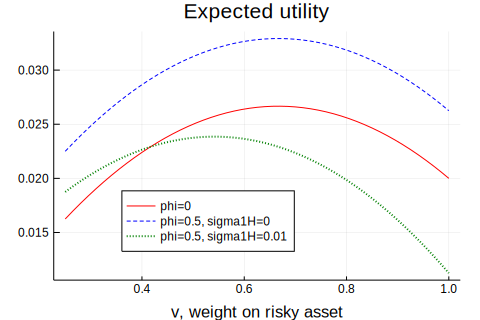

In [5]:
println("Notice: with σ1H=0, the choice of v is not affected by ϕ")

p1 = plot(v,EUM[:,1],color=:red,label="phi=0")
plot!(v,EUM[:,2],line=:dash,color=:blue,label="phi=0.5, sigma1H=0 ")
plot!(v,EUM[:,3],line=:dot,color=:green,linewidth=2,label="phi=0.5, sigma1H=0.01")
plot!(legend=:bottom)
title!("Expected utility")
xlabel!("v, weight on risky asset")

# Asset Pricing Implications of Background Risk: Multi-Factor Model

In [6]:
μe = [0.08,0.089]             #avg. excess returns of factors

Ψ = [1 0.5;                   #covariance matrix of [Rm,RH]
     0.5 2]
SH = [0.8;-0.5]                  #Cov(Ri,Rm) and Cov(Ri,RH)

βmult = inv(Ψ)*SH               #coeffs in Ri = βmult'[Rm;RH]
printlnPs("The multiple regression coefficients: ")
printmat(βmult)

μei = βmult'μe
printlnPs("μᵉ according to 2-factor model:")
printmat(μei)

The multiple regression coefficients: 
     1.057
    -0.514

μᵉ according to 2-factor model:
     0.039



# Empirical Test of a 3-Factor Model: Loading Data

In [7]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1,7,13,19,25]]           #use just 5 assets to make the printing easier 

(T,n) = size(Re)                 #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

Recall: estimate $(\alpha_{i},b_{i})$ in the factor model

$R_{it}^{e}  =\alpha_{i}+b_{i}'f_{t} + \varepsilon_{it}$

Test if $\alpha_{i}=0$

Under the Gauss-Markov assumptions, $\textrm{Cov}([\alpha_{i},b_{i}]) = (X'X)^{-1}\textrm{Var}(\varepsilon_{it})$,
where row $t$ of $X$ contains $[1, f_{t}]$. Use element [1,1] of the covariance matrix as the variance of the $\alpha_i$ estimate

In [8]:
x   = [ones(T) Rme RSMB RHML]         #regressors
Σ_1 = inv(x'x)

α     = fill(NaN,n)
tstat = fill(NaN,n)
for i = 1:n                              #loop over the different test assets
    local b_i, residual, Covb
    b_i       = x\Re[:,i]                #OLS
    residual  = Re[:,i] - x*b_i
    α[i]      = b_i[1]
    Covb      = Σ_1*var(residual)   
    tstat[i] = (α[i]-0)/sqrt(Covb[1,1])
end    
println("\nOLS intercepts and t-stats, regressing Re on constant and 3 factors")
printmat([α tstat])


OLS intercepts and t-stats, regressing Re on constant and 3 factors
    -0.513    -2.306
    -0.006    -0.066
     0.030     0.328
    -0.020    -0.206
    -0.015    -0.133

